In [237]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime
import re

# Постановка задачи

Создать датасет реальных и фейковых новостей

- [x]  Соберите данные из двух разных источников (открытый датасет + веб-скрейпинг или API).      
- [x]  Проведите их агрегацию, создав единый датасет.
- [x]  Проведите разведывательный анализ данных (EDA).
- [x]  Постройте базовые визуализации для основных признаков с учетом разметки данных.
- [x]  Опишите возможные применения этих данных в контексте машинного обучения.

**Анализ датасетов и сайтов для парсинга**

Было проанализировано несколько открытых новостных датасетов, сайтов с фейковыми новостями, а также статей о решении задачи по распознаванию реальных и фейковых новостей.

Тематические новостные датасеты, собранные и размеченные автоматически с помощью сервиса сбора и разметки данных Скаути:
- https://huggingface.co/datasets/ScoutieAutoML/russian-news-telegram-dataset
- https://huggingface.co/datasets/ScoutieAutoML/cybersecurity_news_telegram_dataset
- https://huggingface.co/datasets/ScoutieAutoML/russian_oil_gas_news_telegram_dataset
- https://huggingface.co/datasets/ScoutieAutoML/russian-news-telegram-dataset
- https://huggingface.co/datasets/ScoutieAutoML/medical_news_dataset

Тематические новостные датасеты:
- https://www.kaggle.com/datasets/hardtype/rbc-economy-news
- https://www.kaggle.com/datasets/kkhubiev/russian-financial-news

Другие датасеты:
- https://huggingface.co/datasets/IlyaGusev/ru_news (старые датасеты 2012)
- https://github.com/natasha/corus (старые датасеты)
- https://huggingface.co/datasets/kaengreg/ria-news (только текст)
- https://huggingface.co/datasets/vulerols/ru_ria_news (удален)
- https://huggingface.co/datasets/data-silence/rus_news_classifier (только текст и классы по тематикам)

Датасет с разметкой:
- https://www.kaggle.com/datasets/morfifinka/fake-real-news-ru/data

Такой датасет, казалось бы то, что нужно. Но в нем не распределены новости по источникам и не указано, на чем основано расставление меток `agree/disagree`, поэтому брать такой датасет было бы не совсем корректно.

Сайты, которые вероятно распространяют фейки:
- https://news-kherson.ru/
- https://ren.tv/news
- https://stopfals.md/ru/category/21 (устаревшие фейковые сайты и уже неактивные)
- https://vk.com/itsmomsrecipe (подозрительный ресурс, тематика группы не соответсвует новостям, которые публикуются)

Сайты, на которых осуществляют проверку фактов:
- https://provereno.media/
- https://lapsha.media/
- https://www.stopfake.org/ru/category/novosti/
- https://www.forbes.ru/tegi/feyki

Сайты с сатирическими новостями:
- https://panorama.pub/
- https://t.me/s/pezduzalive

Издания, которым можно относительно доверять (но даже на них бывают печатаются непроверенные новости, но быстро удаляются):
- РИА Новости 
- ТАСС
- Интерфакс
- РБК
- Forbes
- Lenta.ru

Статьи:
1. [Как я сделал AI для выявления фейковых новостей с точностью в 95% и чуть не рехнулся](https://habr.com/ru/companies/productivity_inside/articles/347586/)

2. [Automatic Detection of Fake News](https://arxiv.org/abs/1708.07104) — В статье рассказывается в том числе про сбор данных, который во многом производился вручную и краудсерфингом (занимались буквально переписыванием новостей). Итого набрали два датасета с новостями разной тематики и про знаменитостей по 240 шт.

3. [Популярные западные чат-боты «заразились» пропагандой Кремля. Они воспроизводят дезинформацию российской сети Pravda, которую создали для воздействия на ИИ](https://meduza.io/feature/2025/03/15/populyarnye-zapadnye-chat-boty-zarazilis-propagandoy-kremlya) — В статье рассказывается про пропагандийскую сеть сайтов Pravda.

**Сложность сбора данных**

Были выявлены следующие сложности и проблемы в решении задачи:

1. **Формулирование и понимание самой задачи**
    - Как определить критерии фейковости? Неправда в новостях может быть представлена совершенно разными способами, это может быть искажение фактов, их неправильная интерпретация или просто высказывание своего мнения. Отдельной категорией стоит сатира, на мой взгляд, к ней нужно оносится с осторожностью, потому что это все-таки юмор, и при обучении может оказаться бесполезной в определении действительно пагубных ложных новостей.
    - Дисбаланс классов. Совершенно точно данная задача будет содержать дисбаланс классов, так как фейковых новостей всегда меньше реальных.
    - Нужно ли сохранять распределение по тематикам? Например, реальные новости будут разных тематик, а фейковые только про политику. Кажется, что итоговый результат от такого смещения будет не очень.
2. **Непосредственно сбор данных**
    - Фейковые сайты быстро закрываются
    - Иногда фейковые новости могут быть и на проверенных изданиях (но обычно они быстро удаляются)
    - Сложно понять какая новость фейковая без достаточных знаний в доменной области
    - Новостные каналы/сайты имеют разную структуру страниц, что затрудняет и увеличивает время парсинга (социальные сети, сайты, YouTube)
    - Новости имеют модальность (только текст, только картинка или видео, или все вместе)
    - Человеческий фактор (приходилось делать повторный парсинг, так обнаруживались ошибки в нехватке каких-то частей)

**Итоговое решение**

В рамках задачи было решено взять только данные из парсинга, так как в открытых датасетах нет достаточной информации в отношении разметки, а также свежести данных. Фактор изменения языка, появления новых слов и стиля написания также присутсвует.

Шаги:
1. Спарсить сайты — РИА Новости, Lenta.ru и присвоить им метку True (реальные новости)
2. Спарсить сайт — https://provereno.media/ (достать ссылки на фейковые новости)
3. Спарсить ссылки вида — https://tgstat.ru/channel/... и присвоить им метку False (фейковые новости)

Поля для парсинга:
- Ссылка на новость
- Заголовок
- Текст
- Дата публикации
- Количество просмотров
- Тэги / Тематика
- Автор


# Чтение данных

In [238]:
data = pd.read_csv('data/real_fake_news_dataset.csv', index_col=0).reset_index().drop('index', axis=1)
data.shape

(3616, 7)

In [239]:
data.head()

,url,title,full_text,date_published,views,tags,target
0,https://ria.ru/20250402/smi-2008994289.html,"Глава Пентагона впервые не примет участия во встрече по Украине, пишут СМИ","ВАШИНГТОН, 2 апр – РИА Новости. Министр обороны США Пит Хегсет не примет участия во встрече международной коалиции по оказанию военной поддержки Украине, которая запланирована на 11 апреля в Брюсселе, сообщает издание Defense News со ссылкой на источники среди американских и европейских должностных лиц.",23:54 02.04.2025,52,"['В мире', 'США', 'Украина', 'Брюссель', 'Пит Хегсет', 'Дональд Трамп']",True
1,https://ria.ru/20250402/poshliny-2008993829.html,США ввели пошлины на товары из других стран,"ВАШИНГТОН, 2 апр — РИА Новости. Президент США Дональд Трамп объявил о введении новых пошлин на продукцию других стран.",23:53 02.04.2025,60,"['В мире', 'США', 'Тайвань', 'Дональд Трамп', 'Евросоюз', 'Китай']",True
2,https://ria.ru/20250402/vzryv-2008993522.html,Несущие конструкции здания в Перевозе после взрыва газа не повреждены,"НИЖНИЙ НОВГОРОД, 2 апр - РИА Новости. Несущие конструкции офисного здания в городе Перевоз Нижегородской области, где произошел взрыв газовоздушной смеси, не повреждены, сообщает региональное управление МЧС.",23:52 02.04.2025,105,['Нижегородская область'],True
3,https://ria.ru/20250402/tramp-2008993302.html,Трамп раскрыл размер пошлин на товары из ЕС и Китая,"ВАШИНГТОН, 2 апр - РИА Новости. США вводят пошлины в размере 20% на товары из ЕС, 34% - на товары из Китая, заявил в среду президент США Дональд Трамп.",23:51 02.04.2025,405,"['США', 'Китай', 'Тайвань', 'Дональд Трамп', 'Евросоюз']",True
4,https://ria.ru/20250402/bpla-2008993170.html,В Краснодарском крае объявили опасность атаки БПЛА,"МОСКВА, 2 апр - РИА Новости. Опасность атаки БПЛА объявлена в Краснодарском крае, сообщается в приложении МЧС России.",23:50 02.04.2025,64,"['Специальная военная операция на Украине', 'Краснодарский край', 'Россия']",True


# EDA и визуализации

In [240]:
# Предварительный просмотр данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3616 entries, 0 to 3615
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             3616 non-null   object
 1   title           2554 non-null   object
 2   full_text       3611 non-null   object
 3   date_published  3613 non-null   object
 4   views           3276 non-null   object
 5   tags            2554 non-null   object
 6   target          3616 non-null   bool  
dtypes: bool(1), object(6)
memory usage: 173.2+ KB


In [241]:
# Распределение целевой переменной
data['target'].value_counts(normalize=True)

target
True     0.706305
False    0.293695
Name: proportion, dtype: float64

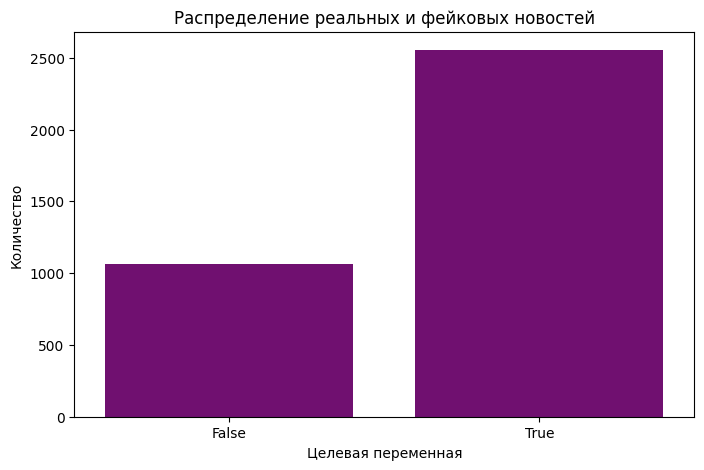

In [242]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(8,5))
sns.countplot(x='target', data=data, color='purple')
plt.title('Распределение реальных и фейковых новостей')
plt.xlabel('Целевая переменная')
plt.ylabel('Количество')
plt.show()

In [243]:
# Анализ пропущенных значений
data.isnull().sum()

url                  0
title             1062
full_text            5
date_published       3
views              340
tags              1062
target               0
dtype: int64

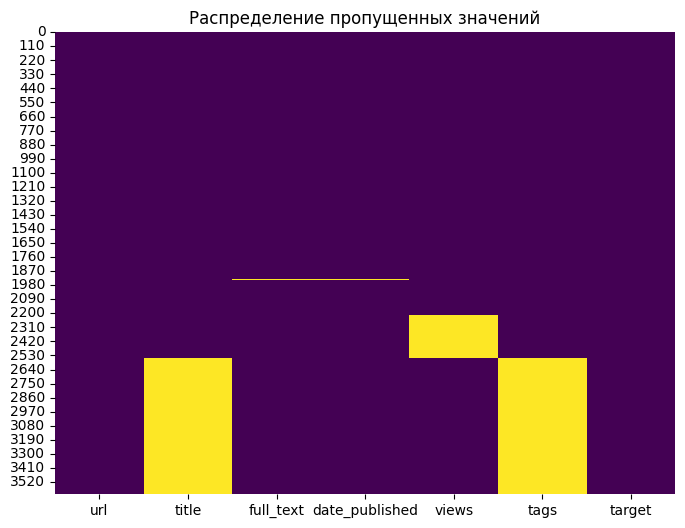

In [244]:
# Визуализация пропущенных значений
plt.figure(figsize=(8, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Распределение пропущенных значений')
plt.show()

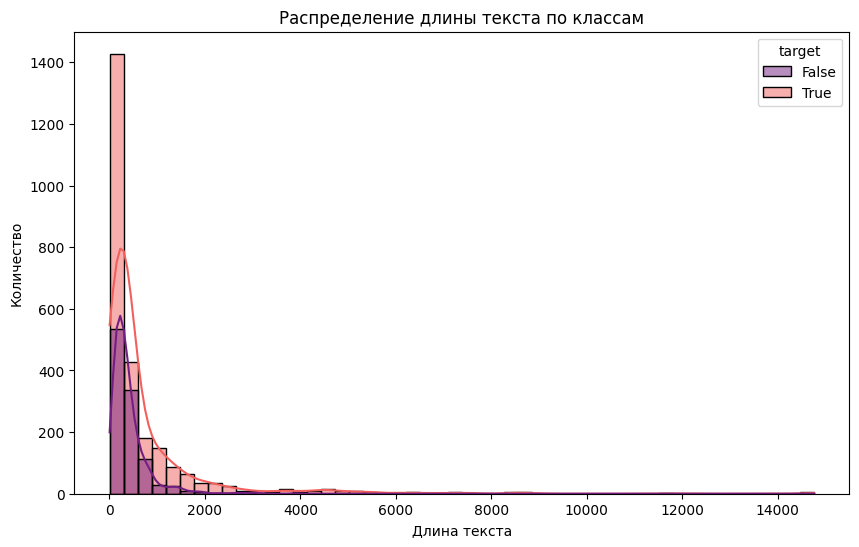


Статистика длины текста по классам:
         count        mean          std  min    25%    50%    75%      max
target                                                                    
False   1062.0  402.886064   391.481053  3.0  168.0  298.0  484.5   3898.0
True    2554.0  714.351605  1287.514370  3.0  203.0  265.0  711.0  14768.0


In [245]:
# Анализ длины текста
if 'full_text' in data.columns and data['full_text'].notna().any():
    data['text_length'] = data['full_text'].astype(str).apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='text_length', hue='target', bins=50, kde=True, palette='magma')
    plt.title('Распределение длины текста по классам')
    plt.xlabel('Длина текста')
    plt.ylabel('Количество')
    plt.show()
    print("\nСтатистика длины текста по классам:")
    print(data.groupby('target')['text_length'].describe())

In [246]:
data[data['target']==True][['title', 'full_text']].loc[0]

title                                                                                                                                                                                                                                              Глава Пентагона впервые не примет участия во встрече по Украине, пишут СМИ
full_text    ВАШИНГТОН, 2 апр – РИА Новости. Министр обороны США Пит Хегсет не примет участия во встрече международной коалиции по оказанию военной поддержки Украине, которая запланирована на 11 апреля в Брюсселе, сообщает издание Defense News со ссылкой на источники среди американских и европейских должностных лиц.
Name: 0, dtype: object

In [247]:
data[data['target']==True][['title', 'full_text']].loc[2000]

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [248]:
data[data['target']==False][['title', 'full_text']].loc[3206]

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               NaN
full_text    «Запрещена вся политическая деятельность, включая протесты»\nНа улицах Сеула заметили военную технику. Командующий военным положением заявил, что вся политическая деятельность запрещена\nНачальник штаба армии Пак Ан Су, командующий штабом по военному положению, заявил, что с 3 декабря «Национальное собрание, местные советы, политические партии, политиче

In [249]:
# Заполнение пропусков строкой
data.fillna('', inplace=True)

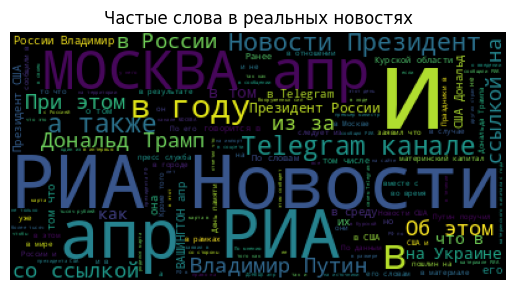

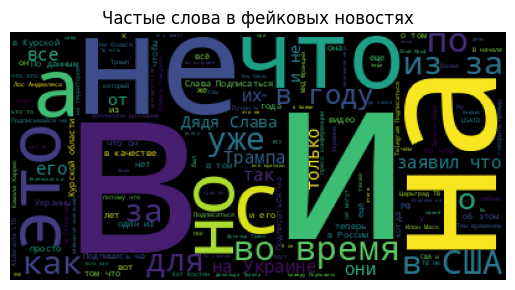

In [250]:
# Анализ частотности слов для реальных новостей
real_text = " ".join(data[data['target'] == True]['full_text'])
wordcloud = WordCloud().generate(real_text)
plt.imshow(wordcloud)
plt.title('Частые слова в реальных новостях')
plt.axis("off")
plt.show()

# Анализ частотности слов для фейковых новостей
fake_text = " ".join(data[data['target'] == False]['full_text'])
wordcloud = WordCloud().generate(fake_text)
plt.imshow(wordcloud)
plt.title('Частые слова в фейковых новостях')
plt.axis("off")
plt.show()

Из графика видно, что требуется очистка текста от стоп-слов, в частности предлогов, частиц, и например, названий новостных изданий.

In [251]:
# Обработка тегов
data['tags_clean'] = (
    df['tags']
    .dropna()
    .astype(str)
    .str.split(', ')
    .explode()
    .str.replace(r"['\[\]]", "", regex=True)
    .str.strip()
    .reset_index(drop=True)  # Сбрасываем индекс, чтобы избежать дубликатов
)

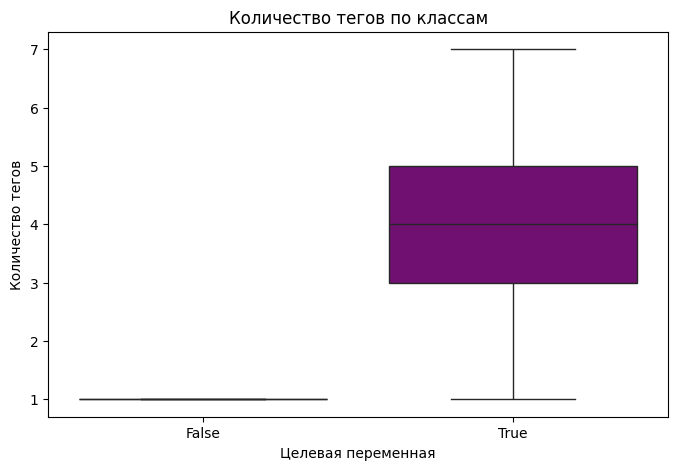

In [252]:
# Анализ количества тегов
if 'tags' in data.columns and data['tags'].notna().any():
    data['num_tags'] = data['tags'].astype(str).apply(lambda x: len(x.split(',')) if x != 'nan' else 0)
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='target', y='num_tags', data=data, color='purple')
    plt.title('Количество тегов по классам')
    plt.xlabel('Целевая переменная')
    plt.ylabel('Количество тегов')
    plt.show()

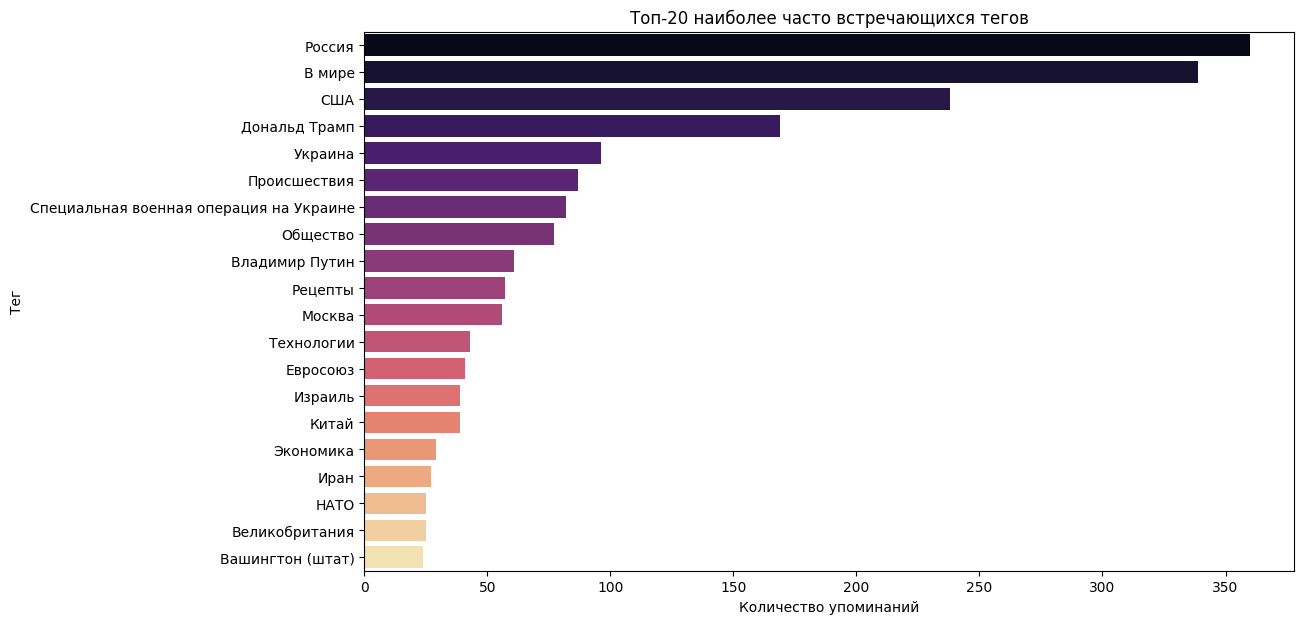

In [253]:
# Анализ наиболее часто встречающихся тегов
if 'tags' in data.columns and data['tags_clean'].notna().any():
    all_tags = data['tags_clean'].dropna().astype(str).str.split(', ').explode()
    top_tags = all_tags.value_counts().nlargest(20)
    plt.figure(figsize=(12, 7))
    sns.barplot(x=top_tags.values, y=top_tags.index, hue=top_tags.index, palette='magma')
    plt.title('Топ-20 наиболее часто встречающихся тегов')
    plt.xlabel('Количество упоминаний')
    plt.ylabel('Тег')
    plt.show()

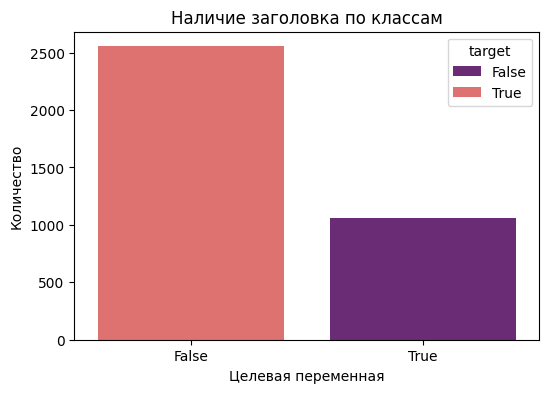

In [254]:
# Анализ наличия заголовков
if 'title' in data.columns:
    data['title_present'] = data['title'] == ''
    plt.figure(figsize=(6, 4))
    sns.countplot(x='title_present', hue='target', data=data, palette='magma')
    plt.title('Наличие заголовка по классам')
    plt.xlabel('Целевая переменная')
    plt.ylabel('Количество')
    plt.show()

In [255]:
# Преобразование даты
def parse_custom_date(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str):
        return pd.NaT
    
    date_str = date_str.strip()
    
    month_translation = {
        'января': '01', 'февраля': '02', 'марта': '03',
        'апреля': '04', 'мая': '05', 'июня': '06',
        'июля': '07', 'августа': '08', 'сентября': '09',
        'октября': '10', 'ноября': '11', 'декабря': '12'
    }
    
    # Формат 1: "00:00, 20 марта 2025"
    match = re.match(r'(\d{2}:\d{2}), (\d{1,2}) ([а-я]+) (\d{4})', date_str)
    if match:
        time_part, day, month, year = match.groups()
        month = month_translation.get(month.lower(), '01')
        return datetime.strptime(f"{day} {month} {year} {time_part}", "%d %m %Y %H:%M")
    
    # Формат 2: "10 Oct 2024, 15:42"
    match = re.match(r'(\d{1,2}) ([A-Za-z]{3}) (\d{4}), (\d{2}:\d{2})', date_str)
    if match:
        day, month, year, time = match.groups()
        return datetime.strptime(f"{day} {month} {year} {time}", "%d %b %Y %H:%M")
    
   # Формат 3: "09:57" (только время) - с фиксированной датой 03.04.2025
    match = re.match(r'(\d{2}:\d{2})', date_str)
    if match:
        fixed_date = datetime(2025, 4, 3).date()
        return datetime.combine(fixed_date, datetime.strptime(match.group(), "%H:%M").time())
    
    return pd.NaT

# Применяем к DataFrame
data['date_published'] = data['date_published'].apply(parse_custom_date)

<Figure size 1200x600 with 0 Axes>

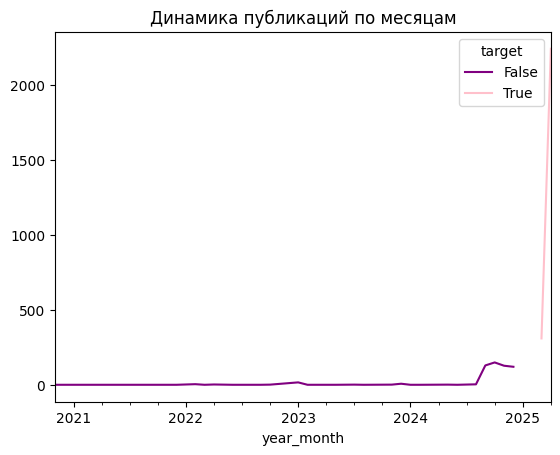

In [256]:
# Анализ дат
data['year_month'] = data['date_published'].dt.to_period('M')
plt.figure(figsize=(12,6))
data.groupby(['year_month','target']).size().unstack().plot(color=['purple', 'pink'])
plt.title('Динамика публикаций по месяцам')
plt.show()

Со стороны распределения по времени публикации все равно получился дисбаланс. Реальные новости попали совсем свежие, а фейковые растянулись на несколько лет.

In [257]:
# Анализ дубликатов
# Группировка по заголовку и тексту с подсчётом повторений
dup_counts = data.groupby(['title', 'full_text']).size().reset_index(name='counts')
dup_counts = dup_counts[dup_counts['counts'] > 1].sort_values('counts', ascending=False)

print(f"Уникальных пар (заголовок + текст), которые повторяются: {len(dup_counts)}")
dup_counts.head()

Уникальных пар (заголовок + текст), которые повторяются: 560


,title,full_text,counts
1602,США ввели пошлины на товары из других стран,"ВАШИНГТОН, 2 апр — РИА Новости. Президент США Дональд Трамп объявил о введении новых пошлин на продукцию других стран.",11
1386,Несущие конструкции здания в Перевозе после взрыва газа не повреждены,"НИЖНИЙ НОВГОРОД, 2 апр - РИА Новости. Несущие конструкции офисного здания в городе Перевоз Нижегородской области, где произошел взрыв газовоздушной смеси, не повреждены, сообщает региональное управление МЧС.",11
1215,"Глава Пентагона впервые не примет участия во встрече по Украине, пишут СМИ","ВАШИНГТОН, 2 апр – РИА Новости. Министр обороны США Пит Хегсет не примет участия во встрече международной коалиции по оказанию военной поддержки Украине, которая запланирована на 11 апреля в Брюсселе, сообщает издание Defense News со ссылкой на источники среди американских и европейских должностных лиц.",11
1604,"США и Израиль готовят сокрушительные удары по Ирану, пишет Daily Mail","МОСКВА, 2 апр - РИА Новости. США и Израиль готовятся нанести по Ирану удар, призванный ликвидировать угрозу, якобы исходящую от иранской ядерной программы, сообщает газета Daily Mail со ссылкой на источники в израильском правительстве.",10
1284,"Иран не закрывал небо, вопреки сообщениям СМИ, следует из расписания рейсов","ТЕГЕРАН, 2 апр – РИА Новости. Воздушное пространство на территории Исламской республики Иран открыто, следует из расписания международного аэропорта имени Имама Хомейни в Тегеране.",10


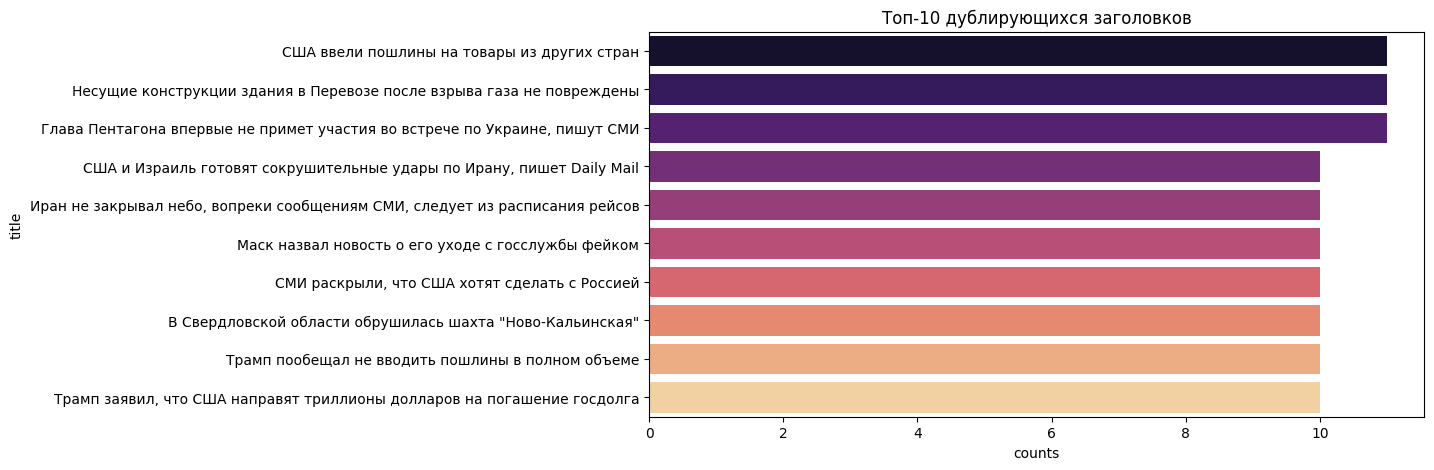

In [258]:
# Визуализация дубликатов
plt.figure(figsize=(10, 5))
sns.barplot(data=dup_counts.head(10), x='counts', y='title', hue='title', palette='magma')
plt.title('Топ-10 дублирующихся заголовков')
plt.show()

Так как пришлось парсить сайт РИА Новости несколько раз, в датасете присутсвуют дубликаты.

**Дальнейшие шаги:**

Датасет требует дополнительной обработки и анализа для дальнейшего применения в обучении, например, заполнения пропусков, перевод слов в токены, удаления дубликатов, построения дополнительных признаков.

# Возможные применения данных

Собранные данные о новостях могут быть полезны в следующих задачах машинного обучения при условии дополнительного обогощения данными и осуществления разметки под конкретную задачу.

- Классификация новостей на реальные и фейковые
- Определение степени фейковости новостей
- Анализ источников фейковых новостей (в данном случае нужно во много раз увеличить датасет и обоготить разными платформами)
- Классификация новостей по тематике
- Анализ эмоциональной окраски новостей (Sentiment Analysis)
- Выявление схожих новостей (Semantic Similarity)
- Генерация кратких обзоров новостей (Summarization)
- Прогнозирование того, станет ли новость вирусной